# **CS 181 HW6 Problem 2 - Policy and Value Iteration**
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

## Util methods to represent the grid (do not modify)
#### You do not need modify any of these methods to complete Problem 2

In [ ]:
# Maze state is represented as a 2-element NumPy array: (Y, X). Increasing Y is South.
grid = [
    'o.x.u',
    '..y..',
    '..y.*',
    '..z..']
topology = np.array([list(row) for row in grid])
flat_topology = topology.ravel()
rewards = {'.': 0, '*': 50, 'o': 4, 'u': 20, 'x': -10, 'y': -50,'z': -20}

row_count = len(grid) # 4
col_count = len(grid[0]) # 5
shape = (row_count, col_count) # (4, 5)

# Possible actions, expressed as (delta-y, delta-x)
directions="NSEW"
maze_actions = {
    'N': np.array([-1, 0]),
    'S': np.array([1, 0]),
    'E': np.array([0, 1]),
    'W': np.array([0, -1]),
}
actions = [maze_actions[direction] for direction in directions]


# Returns true if pos (y,x) is out of bounds
def is_wall(pos):
    (y, x) = pos
    return (y < 0 or y >= row_count or x < 0 or x >= col_count)

# Input is a flattened state, returns the reward at that state
def get_reward(state):
    assert (state in range(num_states)), f"get_reward: State was not an integer representing an in-bounds state ({state} was given)"
    return rewards.get(flat_topology[int(state)])

# Input is a flattened state, returns the unflattened representation of the state
def unflatten_index(flattened_index):
    return np.unravel_index(flattened_index, shape)

# Input state is an unflattened position and action is an index into the actions[] array
# Returns a tuple containing the new position of taking the action from the state
def move(state, action):
    return tuple((state + actions[action]).reshape(1, -1)[0])

# Returns an array of the "side states" when taking action beginning at unflattened position state
# Does not return states which are out of bounds
def get_side_states(action, state):
    side_states = []
    
    if action == 0 or action == 1:
        if not is_wall(move(state, 3)):
            side_states.append(move(state, 3))
        if not is_wall(move(state, 2)):
            side_states.append(move(state, 2))
    elif action == 2 or action == 3:
        if not is_wall(move(state, 0)):
            side_states.append(move(state, 0))
        if not is_wall(move(state, 1)):
            side_states.append(move(state, 1))
            
    return side_states
    
# Inputs s1, s2 are flattened states, action represents an index into the actions array
# Returns p(s2 | s1, action)
def get_transition_prob(s1, action, s2):
    # Check the inputs are valid
    assert (action in [0,1,2,3]), f"get_transition_prob: Action needs to be an integer in [0,1,2,3], but {action} was given"
    assert (s1 in range(num_states)), f"get_transition_prob: Input s1 was not an integer representing an in-bounds state ({s1} was given)"
    assert (s2 in range(num_states)), f"get_transition_prob: Input s2 was not an integer representing an in-bounds state ({s2} was given)"
    
    state1 = unflatten_index(int(s1))
    state2 = unflatten_index(int(s2))
    action = int(action)

    new_state = move(state1, action)

    sstates = get_side_states(action, state1)
    succeed_prb = 0.8
    slip_prb = 0.1

    # One of the side states was a wall: adjust probabilities accordingly.
    if len(sstates) == 1:
        succeed_prb = 0.9

    if is_wall(new_state):
        if(state1 == state2):
            return succeed_prb
    else:
        if(state2 == new_state):
            return succeed_prb

    # Oherwise, check if state2 is on either side
    for side_state in sstates:
        if(state2 == side_state):
            return slip_prb

    return 0.

In [ ]:
# MAKE PLOTS (do not modify)

# Util to draw the value function V as numbers on a plot.
def make_value_plot(V):
    # Useful stats for the plot
    value_function = np.reshape(V, shape)

    # Write the value on top of each square
    indx, indy = np.arange(row_count), np.arange(col_count)

    fig, ax = plt.subplots()
    ax.imshow(value_function, interpolation='none', cmap= plt.get_cmap('coolwarm_r'))

    for s in range(len(V)):
        val = V[s]
        (xval, yval) = unflatten_index(s)
        t = "%.2f"%(val,) # format value with 1 decimal point
        ax.text(yval, xval, t, color='black', va='center', ha='center', size=15)
        

# Util to draw the policy pi as arrows on a plot.
def make_policy_plot(pi, iter_type, iter_num):
    # Useful stats for the plot
    row_count = len(grid)
    col_count = len(grid[0])
    policy_function = np.reshape(pi, shape)

    for row in range(row_count):
        for col in range(col_count):
            if policy_function[row,col] == 0:
                dx = 0; dy = -.5
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = .5; dy = 0
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            plt.arrow( col , row , dx , dy , shape='full', fc='w' , ec='gray' , lw=1., length_includes_head=True, head_width=.1 )
    plt.title(iter_type + ' Iteration, i = ' + str(iter_num))
    # plt.savefig(iter_type + '_' + str(iter_num) + '.png')
    plt.show()

## Please read the rest of this file before beginning to code

In [ ]:
np.random.seed(181)
VALUE_ITER = 'Value'
POLICY_ITER = 'Policy'

num_states = shape[0] * shape[1] # num_states = 20
num_actions = len(actions) # num_actions = 4

# TO-DOS FOR PROBLEM 2
Below you will implement policy and value iteration.

A state is represented as an integer from ``0`` to ``num_states - 1``
<br>
An action is represented as an integer in ``[0,1,2,3]``, which represents the four cardinal directions [N,S,E,W]

``pi`` contains the learned policy at each state, represented by an array of length ``num_states``. In this exercise we will be implementing a deterministic policy, so each state has exactly one action associated with it.
<br>
ex: [2, 3, 1, 1, 2, 0, 1, 2, 2, 1, 3, 0, 0, 2, 2, 1, 3, 3, 2, 0]

``V`` represents the learned value function at each state. Like the above, it is also represented as an array of length ``num_states`` where the entry at index ``i`` represents the value of state ``i``.


## Helper methods

Recall that when you take an action in Gridworld, you won't always necessarily move in that direction. Instead there is some probability of moving to a state on either side. You do not need to calculate these transition probabilities yourself. Please use the helper functions ``get_transition_prob`` and ``get_reward`` in this file. The method headers are listed below:

``get_reward(state):`` Input is a state, output is the reward at that state

``get_transition_prob(s1, a, s2):`` Returns the probability of transitioning from state ``s1`` to state ``s2`` upon taking action ``a``.

An example is given below:

In [ ]:
# Example usage
print(get_reward(14))
print(get_transition_prob(16, 0, 11))

50
0.8


## 1a) Policy Evaluation

Returns array ``V`` representing the value of policy ``pi`` using discount factor ``gamma``

Note: You can do this either closed-form or iteratively. If performed iteratively, please use a convergence tolerance of at least ``0.0001``

In [ ]:
# TODO: Complete this function
def policy_evaluation(pi, gamma):
    theta = 0.0001
    V_0 = np.zeros(num_states)
    V = np.zeros(num_states)
    
    while True:
        V_0 = np.array(V)
        for state in range(num_states):
            current_reward = get_reward(state)
            expected_reward = 0
            for next_state in range(num_states):
                expected_reward += gamma * get_transition_prob(state, pi[state], next_state) * V_0[next_state]
            V[state] = current_reward + expected_reward

        if max(abs(V - V_0)) < theta:
            break

    return V

## 1b) Policy Iteration

Now that we have ``V`` computed in 1a), perform **one step** of policy iteration to return the updated policy ``pi_new``

In [ ]:
# TODO: Complete this function
def update_policy_iteration(V, gamma):
    pi_new = np.zeros(num_states)

    for state in range(num_states):
        max_val = get_reward(state)
        for next_state in range(num_states):
            max_val += gamma * get_transition_prob(state, 0, next_state) * V[next_state]
        
        for action in range(1,num_actions):
            current_reward = get_reward(state)
            expected_reward = 0
            for next_state in range(num_states):
                expected_reward += gamma * get_transition_prob(state, action, next_state) * V[next_state]
            new_val = current_reward + expected_reward
            if new_val > max_val and pi_new[state] != action:
                pi_new[state] = action
                max_val = new_val

    return pi_new

## 2) Value Iteration
Given a value function ``V`` and a policy ``pi``, perform **one step** of value iteration and return the updated ``V_new``, ``pi_new``

In [ ]:
# TODO: Complete this function
def update_value_iteration(V, pi, gamma):
    V_new = np.zeros(num_states)
    pi_new = np.zeros(num_states)

    for state in range(num_states):
        max_val = -99999999999999
        for action in range(0,num_actions):
            current_reward = get_reward(state)
            expected_reward = 0
            for next_state in range(num_states):
                expected_reward += gamma * get_transition_prob(state, action, next_state) * V[next_state]
            new_val = current_reward + expected_reward
            if new_val > max_val:
                max_val = new_val
                V_new[state] = max_val
                pi_new[state] = action

    return V_new, pi_new

# Run code, plot results

The ``learn_strategy`` method iteratively runs the one-step methods you wrote in parts 1 and 2, either until the value function converges under <TT>ct</TT> or until a specified number of iterations <TT>max_iter</TT> have elapsed. It will also print out intermediate plots of the learned policy and value function at intervals of <TT>print_every</TT>. The arguments of the function are listed in more detail below:

``planning_type`` (<TT>string</TT>): 
    Specifies whether value or policy iteration is used to learn the strategy.
    
``max_iter`` (<TT>int</TT>):
    The maximum number of iterations (i.e. number of updates) the learning
    policy will be run for.
    
``print_every`` (<TT>int</TT>):
    The frequency at which the function will print value and policy plots.
    
``ct`` (<TT>float</TT>):
    The convergence tolerance used for policy or value iteration.
    
``gamma`` (<TT>float</TT>):
    The discount factor.

In [ ]:
# Do not modify the learn_strategy method, but read through its code
def learn_strategy(planning_type = VALUE_ITER, max_iter = 10, print_every = 5, ct = None, gamma = 0.7):
    # Loop over some number of episodes
    V = np.zeros(num_states)
    pi = np.zeros(num_states)

    # Update Q-table using value/policy iteration until max iterations or until ct reached
    for n_iter in range(max_iter):
        V_prev = V.copy()

        # Update V and pi using value or policy iteration.
        if planning_type == VALUE_ITER:
            V, pi = update_value_iteration(V, pi, gamma)
        elif planning_type == POLICY_ITER:
            V = policy_evaluation(pi, gamma)
            pi = update_policy_iteration(V, gamma)
        
        # Calculate the difference between this V and the previous V
        diff = np.absolute(np.subtract(V, V_prev))

        # Check that every state's difference is less than the convergence tol
        if ct and np.max(diff) < ct:
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)
            print("Converged at iteration " + str(n_iter+1))
            return 0

        # Make value plot and plot the policy
        if (n_iter % print_every == 0):
            make_value_plot(V = V)
            make_policy_plot(pi = pi, iter_type = planning_type, iter_num = n_iter+1)

## Show Policy Iteration

In [ ]:
import time

In [ ]:
start_time = time.time()

print('Beginning policy iteration.')
learn_strategy(planning_type=POLICY_ITER, max_iter = 100, print_every = 1, ct = 0.01, gamma = 0.9)
print('Policy iteration complete.\n')

print(f"Total time: " + str(time.time()-start_time))
print(f"Average time per step: " + str((time.time()-start_time)/5))

## Show Value Iteration

Beginning value iteration.


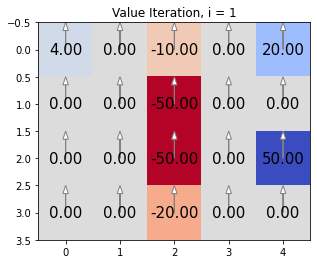

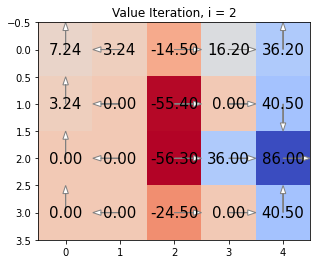

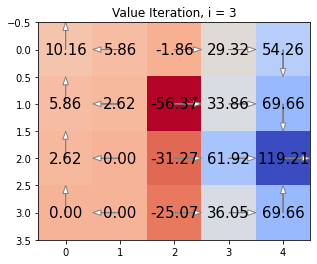

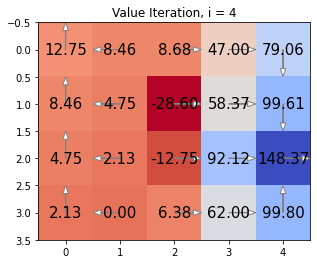

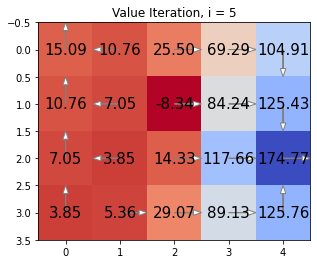

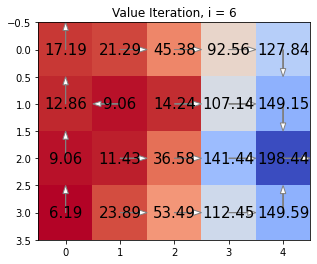

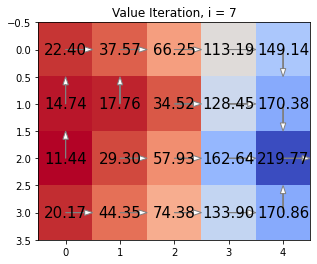

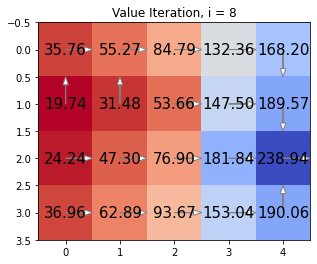

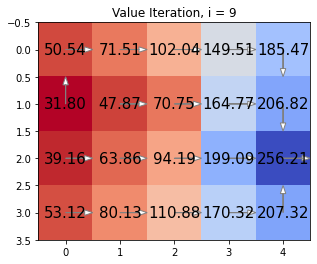

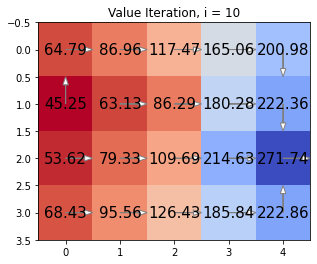

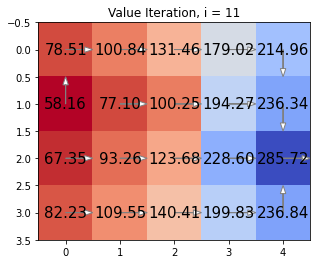

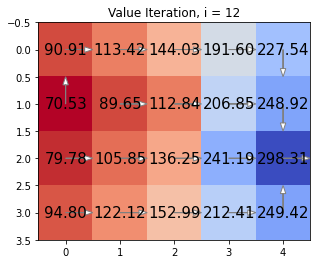

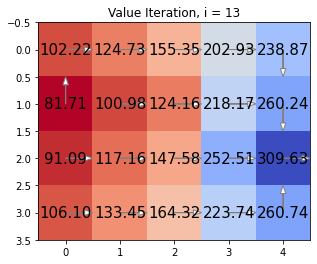

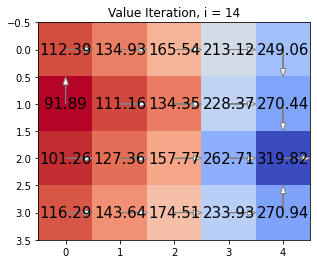

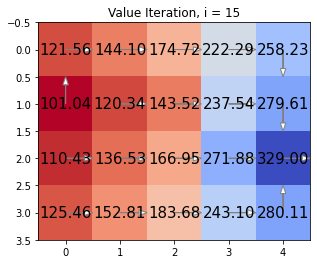

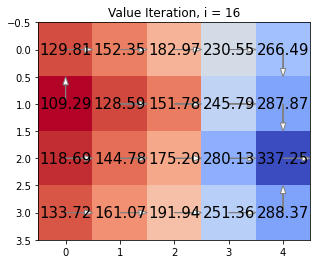

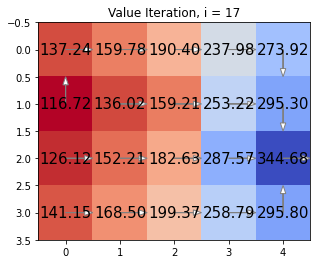

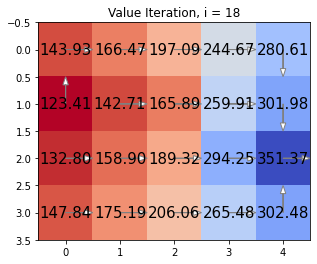

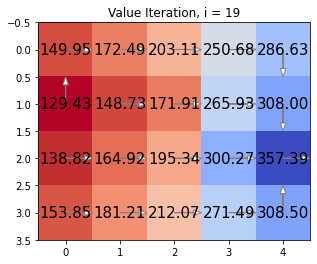

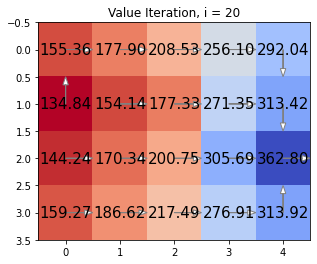

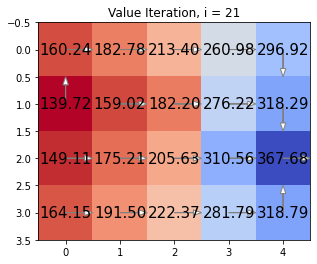

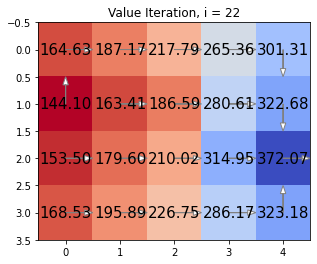

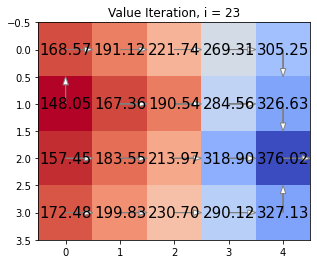

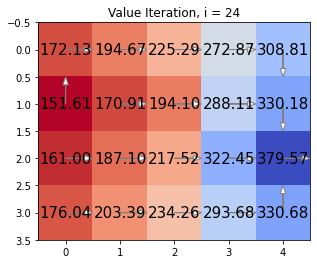

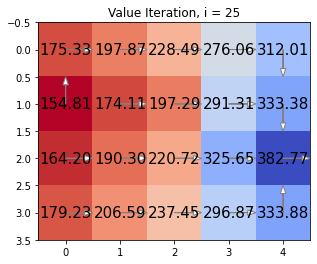

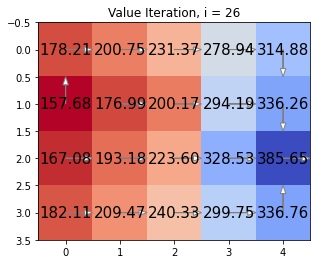

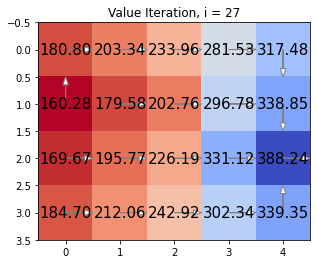

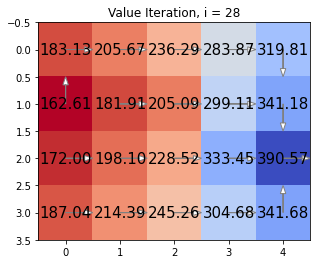

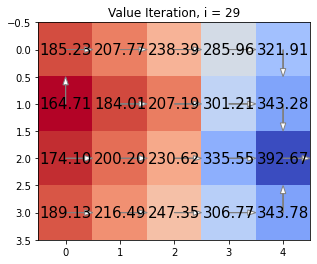

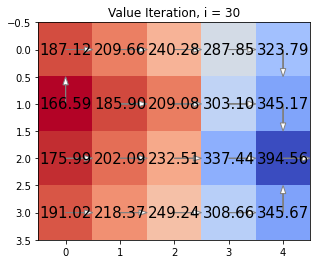

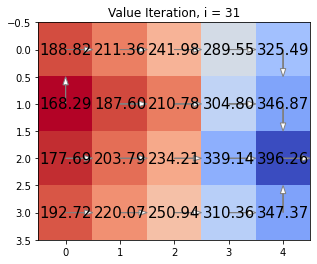

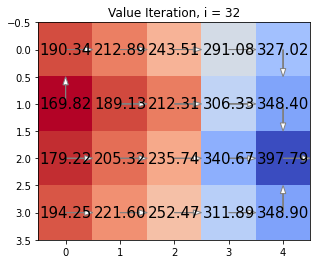

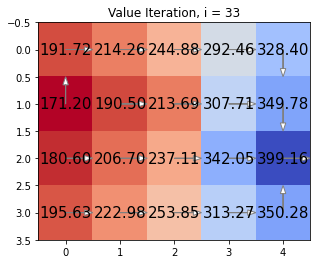

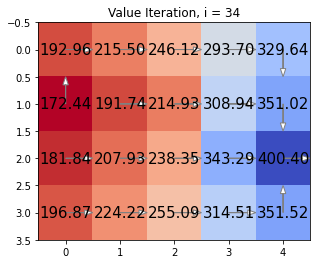

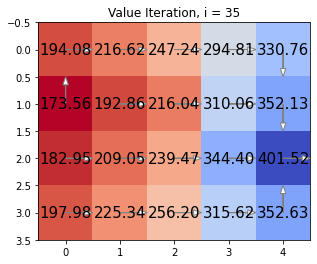

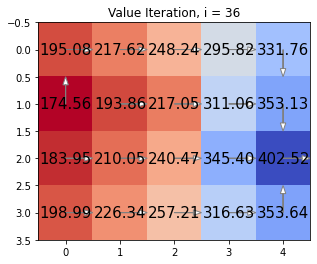

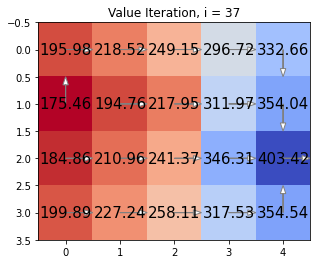

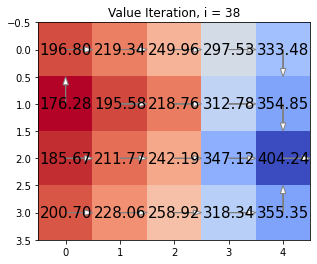

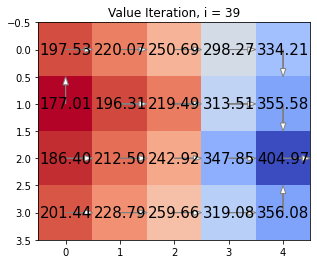

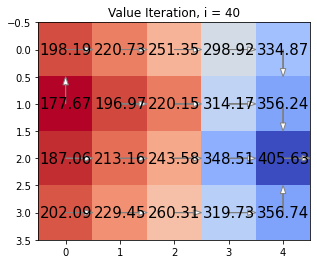

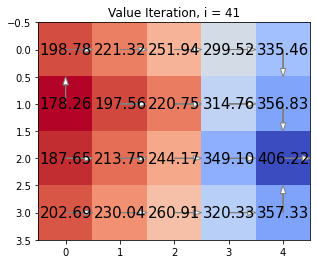

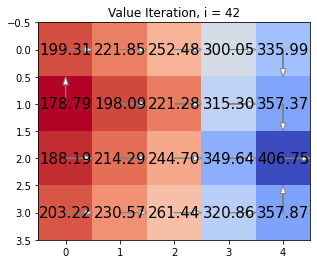

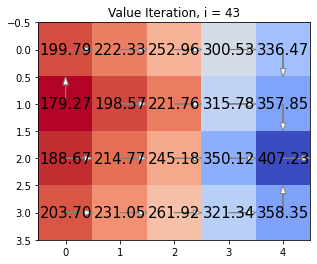

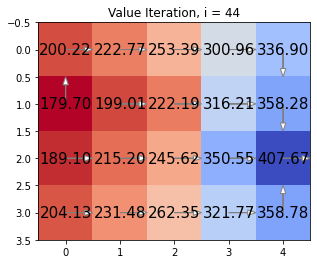

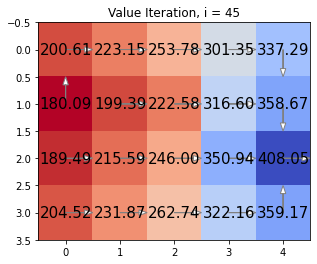

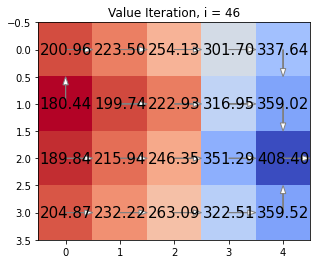

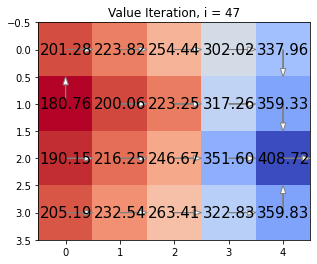

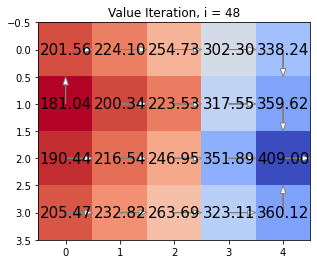

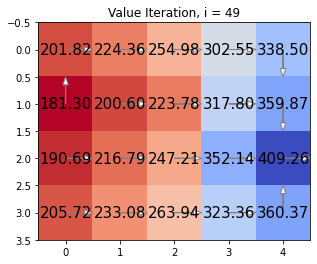

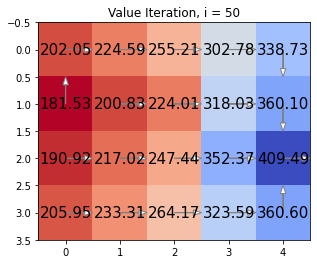

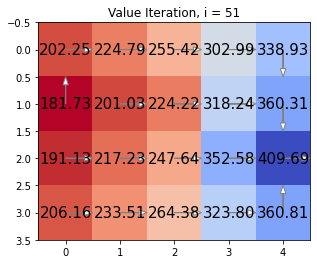

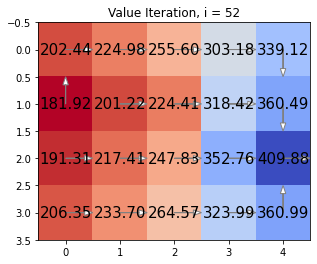

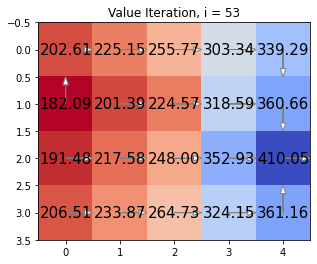

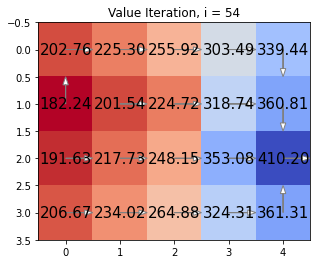

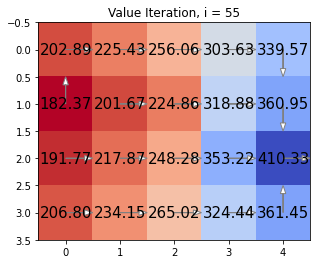

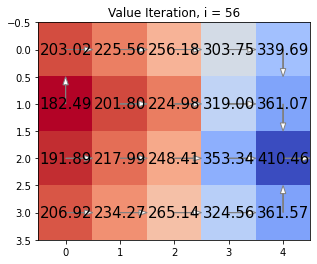

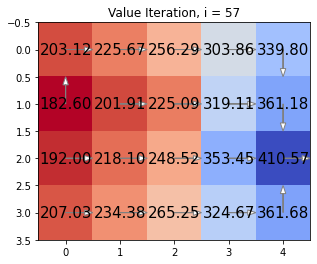

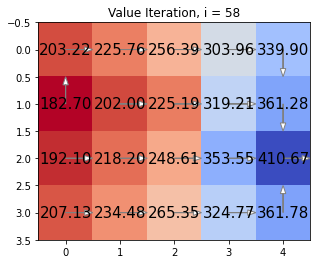

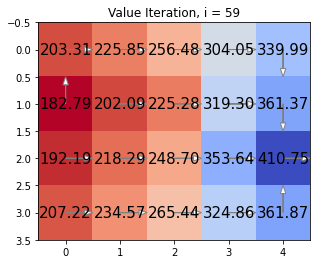

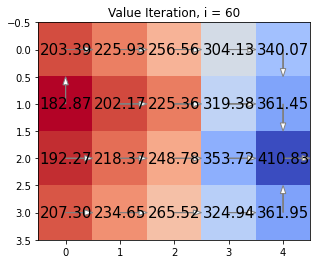

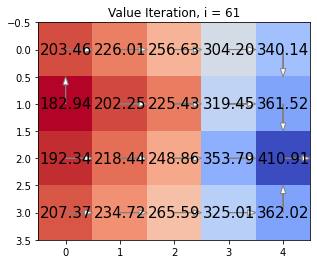

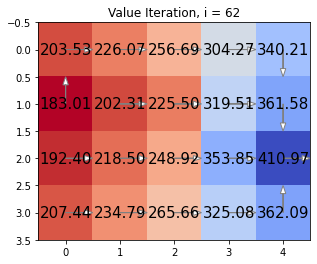

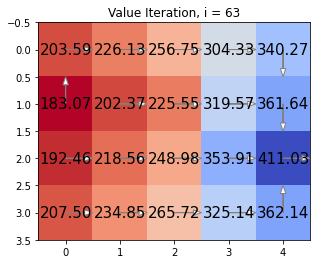

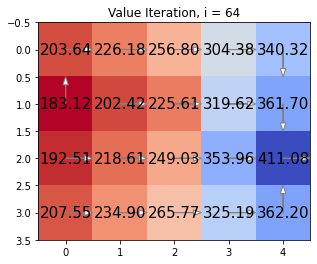

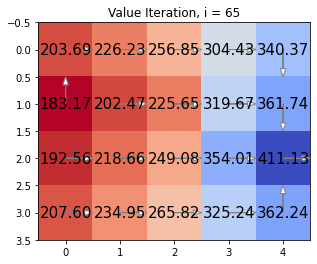

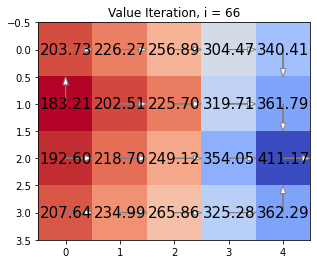

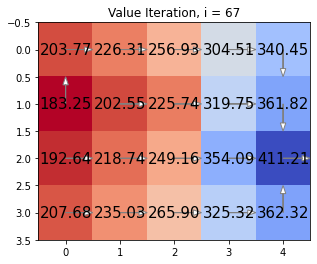

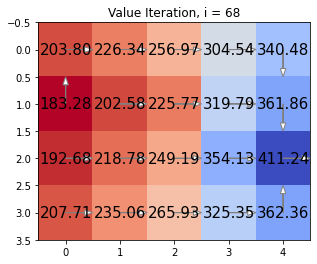

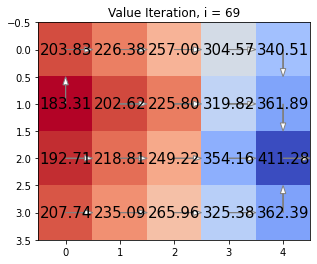

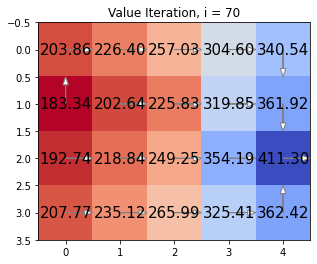

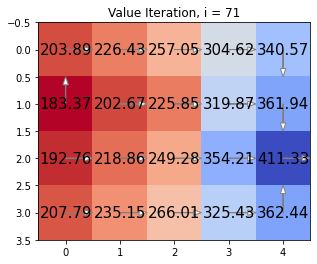

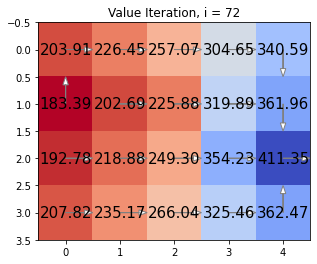

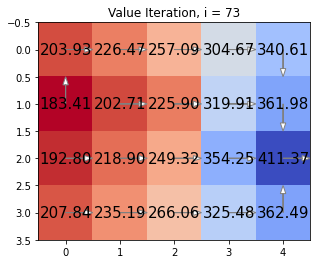

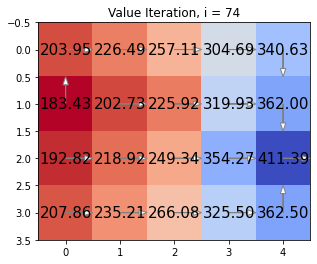

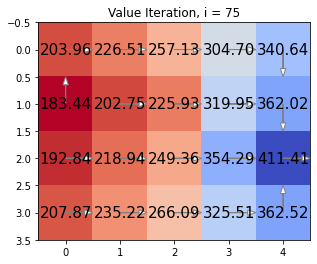

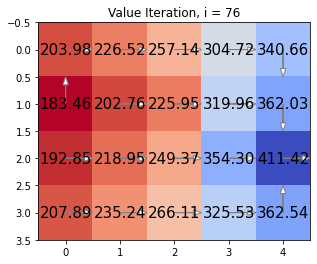

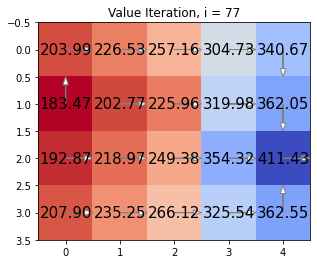

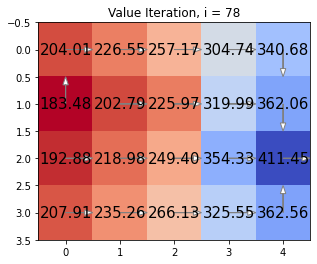

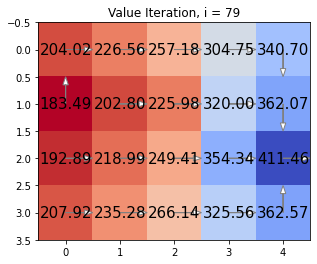

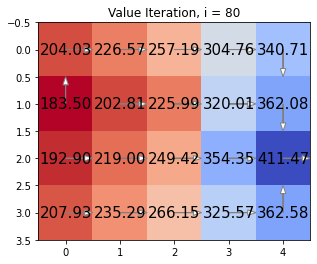

Converged at iteration 80
Value iteration complete.

Total time: 21.64438009262085
Average time per step: 0.8657786560058593


In [ ]:
start_time = time.time()

print('Beginning value iteration.')
learn_strategy(planning_type=VALUE_ITER, max_iter = 100, print_every = 1, ct = 0.01, gamma = 0.9)
print('Value iteration complete.\n')

print(f"Total time: " + str(time.time()-start_time))
print(f"Average time per step: " + str((time.time()-start_time)/25))